Question 1. Start from 2024-3-22, 16:00


Under risk neutral measure Q, the probability of each different final price of underlying S is

$$Q(S_n=s_k^n)=Q(S_n=S_0u^{n-k}d^k = C_k^n(1-q)^kq^{n-k},$$
where $u=1+v$, $d=1-v$ and $q=\frac{1}{2}$ in our scenario.

For a European option with payoff function $g(S_N)$ at time $N$, the time n fair price of the option is
$$V^n=e^{-r(N-n)\Delta t}E_Q[g(S_N)|F_n]$$,
where in our case $r=0$, so no discounting term.
With
$$g(S_N)= \max(0,K-S_N)$$
for an European put option, then time-zero option price is,
$$V^0=E_Q[g(S_N)]=\sum_{k=0}^NC_k^N\frac{1}{2^N}g(S_0(1+v)^{n-k}(1-v)^k)$$



In [144]:
from math import comb
from scipy import optimize
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
cashflow = pd.read_excel("Quantitative_Analyst_Case_Study_2024_Cashflow_Model.xlsx")
#global variable S_0
S_0=1.28065

def European_put_option(v, K, N):
   possible_payoff_list = [1/2**N * comb(N, k) * max(0, K - S_0 * (1+v)**(N-k) *(1-v)**k) for k in range(N+1)]
   return sum(possible_payoff_list)


In [145]:
V=European_put_option(0.5, 2, 10)
V

1.3692244359970092

Finish at 16:30

Question 2. Start from 2024-03-25, 19:00.

Brent's method:
Advantage: Robust and reliable, always converge. Capable of handling non-smooth function, which appears in our case.
Disadvantage: Computational overhead. Slower than Newton's method.

Steps：

1. Choose stopping tolerance, with same precision number of $S_0$, $\delta = 0.00001$.
2. Need to find points $a$ and $b$ such that $f(a)f(b) < 0$ and $0<a, b<1$.
3. Use Brent's method existing in scipy package to find the root





In [146]:
TOL = 0.00001
def find_root_intervals(K, V, N):
   intervals=[]
   current_state = TOL
   while (current_state+0.1) < 1:
      next_state = current_state + 0.1
      if (V - European_put_option(current_state, K, N)) * (V - European_put_option(next_state, K, N)) < 0:
        intervals.append([current_state, next_state])
      current_state = next_state
   return intervals


def calibrate_volatilities(K, V, N):
  intervals = find_root_intervals(K, V, N)
  def root_function(v, strike=K, value=V, period=N):
    return value - European_put_option(v, strike, period)
  volatilities = [optimize.brentq(root_function, x[0], x[1], xtol=TOL) for x in intervals]
  return volatilities


In [147]:
find_root_intervals(2, 1.36922, 10)

[[0.40001, 0.50001]]

In [148]:
calibrate_volatilities(2, 1.36922, 10)

[0.49999800628722907]

Question 2. Finish at 2024-03-25, 20:30.

Question 3, start from 2024-03-26, 11:00

Construct a probability grid for all kinds of state with each $N=0,1,\dots,n$, then calculate expectation reversely from $N=n$ to $N=0$
















In [149]:
def calculate_running_max_expectation(S0,v,N):
  prob = np.zeros((N+1,N+1))
  state = np.zeros((N,N))
  # construct probability matrix
  for i in range(N+1):
    for j in range(i,N+1):
      prob[i,j] = comb(j,i)/2**j
  # calculate expectation reversely
  for j in reversed(range(N)):
    for i in range(j+1):
       state[i,j]=prob[i,j+1]*(1+v)**(j+1-i)+prob[i+1,j+1]*(1+v)**(j-i)
  return state[0,0]*S0

In [150]:
calculate_running_max_expectation(1.28065,0.05,10)

1.31266625

Finish at 2024-03-26,11:30


Question 4, start at 1:36

In [151]:
cashflow

,Time,Fund,Cashflow Type,Cashflow Amount (in Local Asset Currecny),Local Asset Currency,Fund Currency,Base Case IRR
0,2024-03-31,Validus V,Equity,-100000000,GBP,USD,0.149925
1,2025-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
2,2026-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
3,2027-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
4,2028-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
5,2029-03-31,Validus V,Proceeds,115000000,GBP,USD,NaN


First define a random path of fx rate based on the defined binary tree.

In [152]:
def generate_fx_path(v, N, S0):
    up_probability = 1/2
    down_probability = 1/2
    possible_outcomes = [1+v, 1-v]
    probabilities = [up_probability, down_probability]
    direction = random.choices(possible_outcomes, weights=probabilities, k=N)
    path = np.cumprod(np.array(direction))
    jump_path = [path[i]*S0 for i in range(N) if i%2==1]
    return [S0] + jump_path

Calculate IRR based on formula:
$$
0 = NPV = \sum^T_{t=1}\frac{CF_t}{(1+IRR)^t}-CF_0
$$


In [153]:
def calculate_IRR(cashflow, S0, v, N):
   local_ccy_cf = cashflow["Cashflow Amount (in Local Asset Currecny)"]
   fund_ccy_cf = local_ccy_cf*generate_fx_path(v, N, S0)
   f = lambda x: fund_ccy_cf[0]+sum([(1+x)**(-1.*i)*fund_ccy_cf[i] for i in range(1,len(fund_ccy_cf))])
   roots = optimize.fsolve(f,[0,1])
   IRR = [round(x,8) for x in roots if x>0 and x<1]
   if len(set(IRR)) !=1:
    raise ValueError("Check cashflow input or there may be more than one value fits in IRR formula")
   return IRR[0]

In [154]:
calculate_IRR(cashflow, 1.28065, 0.05, 10)

0.14879486

Simulate the random path and rerun calculate_IRR for 5000 and 10000 times to draw historical graph. There are 1024 possible different paths, so need to simulate more than 1024 paths.

In [155]:
def perform_simulation(n_times):
   S0=1.28065
   v=0.05
   N=10
   store_IRRs = []
   for i in range(n_times):
    IRR=calculate_IRR(cashflow, S0, v, N)
    store_IRRs.append(IRR)
   return store_IRRs

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Histogram of normal distribution sample with n=5000')

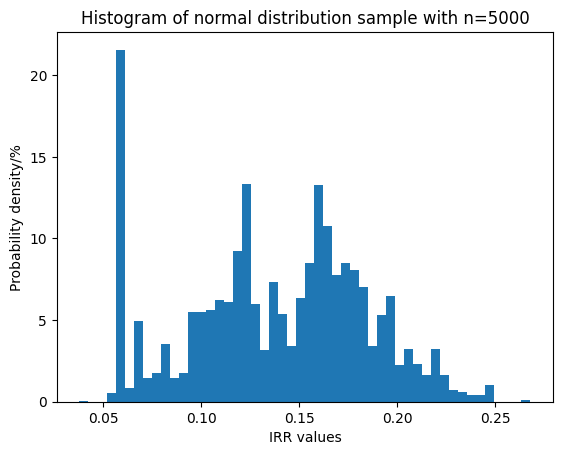

In [156]:
simluation_5000 = perform_simulation(5000)
num_bins = 50
# the histogram of the data
plt.hist(simluation_5000, num_bins, density=True)
plt.xlabel('IRR values')
plt.ylabel('Probability density/%')
plt.title('Histogram of normal distribution sample with n=5000')

Text(0.5, 1.0, 'Histogram of normal distribution sample with n=10000')

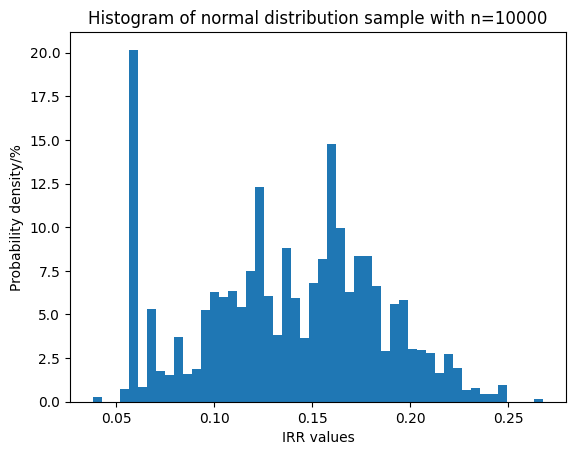

In [157]:
simluation_10000 = perform_simulation(10000)
# the histogram of the data
plt.hist(simluation_10000, num_bins, density=True)
plt.xlabel('IRR values')
plt.ylabel('Probability density/%')
plt.title('Histogram of normal distribution sample with n=10000')

Text(0.5, 1.0, 'Histogram of normal distribution sample with n=15000')

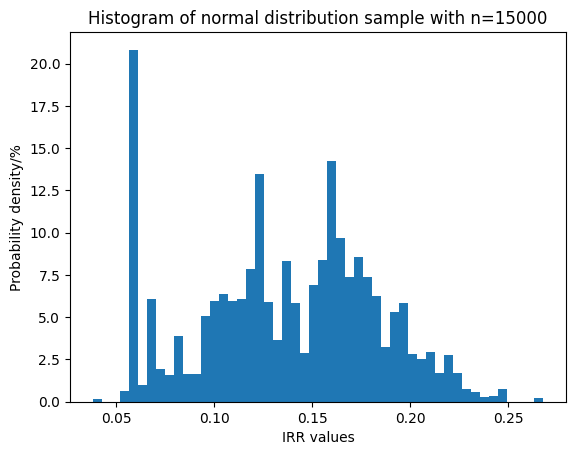

In [158]:
simluation_15000 = perform_simulation(15000)
# the histogram of the data
plt.hist(simluation_15000, num_bins, density=True)
plt.xlabel('IRR values')
plt.ylabel('Probability density/%')
plt.title('Histogram of normal distribution sample with n=15000')

After a few runs with $n=5000, n=10000$ and $n=15000$, the distribution is close to be a symmetric kind of distribution but sligtly skewed to the left, with centre slightly off and to the right of the initial Base Case IRR 15%. There is a significant number of counts around $(0.05, 0.06)$.

The ultimate goal of IRR is to identify the rate of discount. From our simulations and data visualtions, clearly discounting rate should be around 1/(1+5.5%). 5.5% is close to current Fed Fund rate 5.5% or GBP Bank of England Rate 5.25%. If the FX rate curve is correct, this rate curve cound potentially used for foward rate projection and as disounting curve as well.

Finishes at 4:30


Question 5 starts at 9:30

Use Question 1's function then we can have a simple rate European put option, then for fair market value of our GBPUER European put option is
$$
Premium = V_0 * Notional
$$

In [159]:
premium = 1e8 * European_put_option(0.05, 1.28065, 10)
premium

8048787.27535706

Therefore, the option premium is
£80,487,872.7535706.

Finish at 9:40.

Question 6 starts from 9:40.

For the hedged portfolio, now we have two more cashflow from our hedge, the initial pay in premium and the final payoff.

In [160]:
def calculate_hedged_IRR(cashflow, S0, v, N, K):
   local_ccy_cf = cashflow["Cashflow Amount (in Local Asset Currecny)"]
   fund_ccy_cf = local_ccy_cf*generate_fx_path(v, N, S0)
   f = lambda x: (premium+fund_ccy_cf[0])+sum([(1+x)**(-1.*i)*fund_ccy_cf[i] for i in range(1,len(fund_ccy_cf))])+1e8*max(0,K-generate_fx_path(v, N, S0)[-1])
   roots = optimize.fsolve(f,[0,1])
   IRR = [round(x,15) for x in roots if x>0 and x<1]
   return IRR

def perform_simulation(n_times):
   S0=1.28065
   v=0.05
   N=10
   K=1.28065
   store_IRRs = []
   for i in range(n_times):
    IRR=calculate_hedged_IRR(cashflow, S0, v, N, K)
    store_IRRs+=IRR
   return store_IRRs

In [161]:
S0=1.28065
v=0.05
N=10
K=1.28065
calculate_hedged_IRR(cashflow, S0, v, N, K)


[0.321212267881242, 0.674485159744325]

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Histogram of normal distribution sample with n=5000')

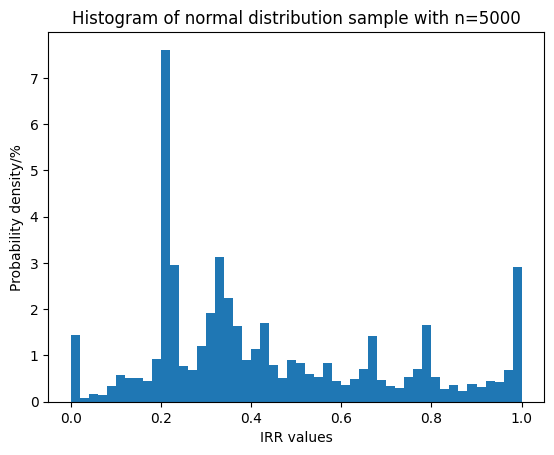

In [162]:
simluation_5000 = perform_simulation(5000)
# the histogram of the data
plt.hist(simluation_5000, num_bins, density=True)
plt.xlabel('IRR values')
plt.ylabel('Probability density/%')
plt.title('Histogram of normal distribution sample with n=5000')

Text(0.5, 1.0, 'Histogram of normal distribution sample with n=10000')

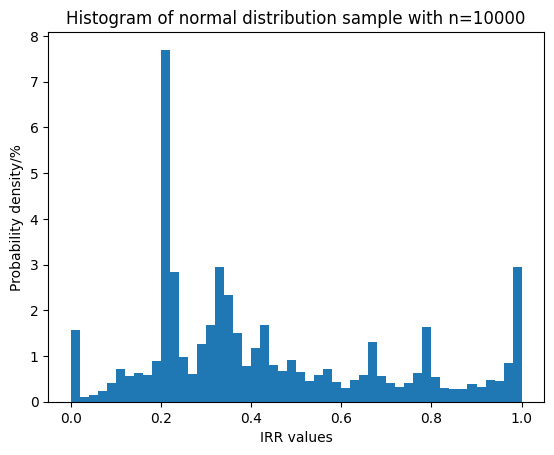

In [163]:
simluation_10000 = perform_simulation(10000)
# the histogram of the data
plt.hist(simluation_10000, num_bins, density=True)
plt.xlabel('IRR values')
plt.ylabel('Probability density/%')
plt.title('Histogram of normal distribution sample with n=10000')

Text(0.5, 1.0, 'Histogram of normal distribution sample with n=15000')

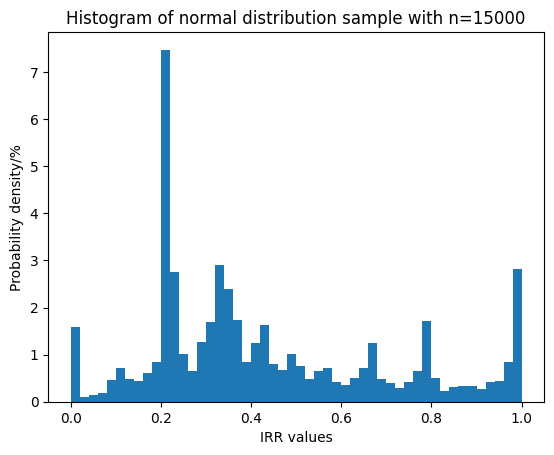

In [164]:
simluation_15000 = perform_simulation(15000)
# the histogram of the data
plt.hist(simluation_15000, num_bins, density=True)
plt.xlabel('IRR values')
plt.ylabel('Probability density/%')
plt.title('Histogram of normal distribution sample with n=15000')

Now the distribution is more centralized and around IRR=20%, and it's more like a tailed distribution with right side a long tail. With both sides have some extreme case close to 0 and 1. Afyer the hedging, IRR (internal rate of returns)gets boosted significantly.

Finish at 10:45

In total, used roughly 6 hours 45 mins in total to finish.